# A/H 溢价季度策略（qs 框架）回测 + 指标 + 仓位建议

- 直接使用 `qs.strategy.ah_premium_quarterly.AHPremiumQuarterlyStrategy`
- 基于 `data/data.sqlite` 现场计算溢价（不依赖任何中间处理库）
- 与沪深 300（`000300.SH`）和纳指（`IXIC`）归一化曲线对比
- 输出关键指标：Sharpe、月胜率、年胜率等
- 基于凯利公式给出整体仓位建议，并输出“当前推荐组合 + 权重”

兼容说明：如果你当前环境的 `matplotlib`/`pandas` 与 `numpy` 版本不兼容（常见于 `numpy>=2` 升级后），Notebook 会自动跳过绘图，但仍会输出曲线数据与指标。

In [1]:
# 环境与依赖（不强依赖 pandas/matplotlib）
import _bootstrap  # noqa: F401 (adds src/ to sys.path)

from pathlib import Path
import datetime as dt
import math

import numpy as np

from qs.backtester.runner import load_calendar_bars_from_sqlite, run_backtest
from qs.sqlite_utils import connect_sqlite
from qs.strategy.ah_premium_quarterly import AHPremiumQuarterlyStrategy

In [2]:
# 可选：绘图库（若导入失败则仅不画图）
try:
    import matplotlib
    import matplotlib.pyplot as plt

    matplotlib.rcParams["axes.unicode_minus"] = False
    # 如本机有中文字体可在此设置：
    # matplotlib.rcParams["font.sans-serif"] = ["Microsoft YaHei", "SimHei", "Arial Unicode MS"]
except Exception as e:
    matplotlib = None
    plt = None
    print("matplotlib unavailable, skip plotting:", repr(e))

In [3]:
# 回测参数
DB_PATH = _bootstrap.RAW_DB_PATH  # robust to notebook cwd
START_DATE = "20180101"
END_DATE = None  # e.g. "20251231"

INIT_CASH = 1_000_000.0
TOP_K = 5
BOTTOM_K = 5
CAPITAL_SPLIT = 0.5  # H leg 权重占比
REBALANCE_MONTH_INTERVAL = 3

# 复权参数：
# - use_adjusted=True：交易执行价/估值价使用“以各自最后交易日为基准”的复权价
# - premium_use_adjusted=True：溢价计算也用复权价（默认与 use_adjusted 保持一致）
USE_ADJUSTED = True
PREMIUM_USE_ADJUSTED = USE_ADJUSTED

if not DB_PATH.exists():
    raise FileNotFoundError(f"Missing DB: {DB_PATH} (run fetch/sync scripts first)")

print("DB:", DB_PATH)

DB: /root/dev/quant_strategy_v2/data/data.sqlite


In [4]:
# 运行回测（qs 回测框架）
bars = load_calendar_bars_from_sqlite(db_path=DB_PATH, start_date=START_DATE, end_date=END_DATE)
print("calendar bars:", len(bars), "from", bars[0].trade_date, "to", bars[-1].trade_date)

strat = AHPremiumQuarterlyStrategy(
    db_path_raw=str(DB_PATH),
    top_k=TOP_K,
    bottom_k=BOTTOM_K,
    start_date=START_DATE,
    capital_split=CAPITAL_SPLIT,
    rebalance_month_interval=REBALANCE_MONTH_INTERVAL,
    use_adjusted=USE_ADJUSTED,
    premium_use_adjusted=PREMIUM_USE_ADJUSTED,
)

res = run_backtest(
    bars=bars,
    strategy=strat,
    initial_cash=INIT_CASH,
    symbol="",  # 多标的
    enable_trade_log=False,
    mark_error_policy="warn",
)

print(f"Final equity: {res.final_equity:,.2f}  Total return: {(res.final_equity/res.initial_cash-1):.2%}")
print(f"Max DD: {res.max_drawdown:.2%}  ({res.dd_peak} -> {res.dd_trough})")
print("Risk (daily):", dict(res.risk))

calendar bars: 2047 from 20180102 to 20260129
[AHPremiumQuarterlyStrategy] __init__ preload factors: 3.194s (premium_use_adjusted=True, interval=3m, base=per-symbol-last)
[AHPremiumQuarterlyStrategy] _load_premium_for_date(20180330): 0.008s, 0 records (premium_use_adjusted=True)
[AHPremiumQuarterlyStrategy] _load_premium_for_date(20180629): 0.010s, 94 records (premium_use_adjusted=True)
[AHPremiumQuarterlyStrategy] _load_opens(20180702): 0.001s, 5 symbols (use_adjusted=True)
[AHPremiumQuarterlyStrategy] rebalance 20180702 premium_date=20180629 A_count=5 H_count=5
  symbol=600585.SH leg=A prem=-6.56% wt=0.1000 A_raw=33.4800 H_raw=38.0637 A_adj=24.0331 H_adj=25.7197 pair=
  symbol=000898.SZ leg=A prem=-4.07% wt=0.1000 A_raw=5.5700 H_raw=5.9887 A_adj=3.6694 H_adj=3.8250 pair=
  symbol=000338.SZ leg=A prem=-2.65% wt=0.1000 A_raw=8.7500 H_raw=9.1522 A_adj=6.6474 H_adj=6.8285 pair=
  symbol=601318.SH leg=A prem=-0.34% wt=0.1000 A_raw=58.5800 H_raw=61.0712 A_adj=43.5311 H_adj=43.6781 pair=
  

In [5]:
# 策略净值序列（list-based）
trade_dates = [p.trade_date for p in res.equity_curve]
equities = [float(p.equity) for p in res.equity_curve]
nav = [e / float(INIT_CASH) for e in equities]
dates = [dt.datetime.strptime(d, "%Y%m%d") for d in trade_dates]

print("points:", len(nav), "first:", trade_dates[0], "last:", trade_dates[-1])
print("nav last:", nav[-1])

points: 2047 first: 20180102 last: 20260129
nav last: 4.779587251307942


In [6]:
# 从 SQLite 读取指数 close，并对齐到策略交易日（缺失前值填充）

def load_close_map(table: str, ts_code: str) -> dict[str, float]:
    con = connect_sqlite(DB_PATH, read_only=True)
    try:
        rows = con.execute(
            f"SELECT trade_date, close FROM {table} WHERE ts_code=? AND trade_date>=? ORDER BY trade_date",
            [ts_code, START_DATE],
        ).fetchall()
    finally:
        con.close()
    return {d: float(c) for d, c in rows if c is not None}


def align_close(trade_dates: list[str], close_map: dict[str, float]) -> list[float] | None:
    # forward-fill along trade_dates
    out: list[float] = []
    last = None
    for d in trade_dates:
        if d in close_map:
            last = close_map[d]
        out.append(last if last is not None else float('nan'))
    if not out or all(math.isnan(x) for x in out):
        return None
    first = next((x for x in out if not math.isnan(x)), None)
    if first is None:
        return None
    out = [first if math.isnan(x) else x for x in out]
    return out

sh300_map = load_close_map('index_daily', '000300.SH')
ixic_map = load_close_map('index_global', 'IXIC')

sh300_close = align_close(trade_dates, sh300_map)
ixic_close = align_close(trade_dates, ixic_map)

hs300_nav = [c / sh300_close[0] for c in sh300_close] if sh300_close else None
ixic_nav = [c / ixic_close[0] for c in ixic_close] if ixic_close else None

print('HS300 points:', 0 if hs300_nav is None else len(hs300_nav))
print('IXIC points:', 0 if ixic_nav is None else len(ixic_nav))

HS300 points: 2047
IXIC points: 2047


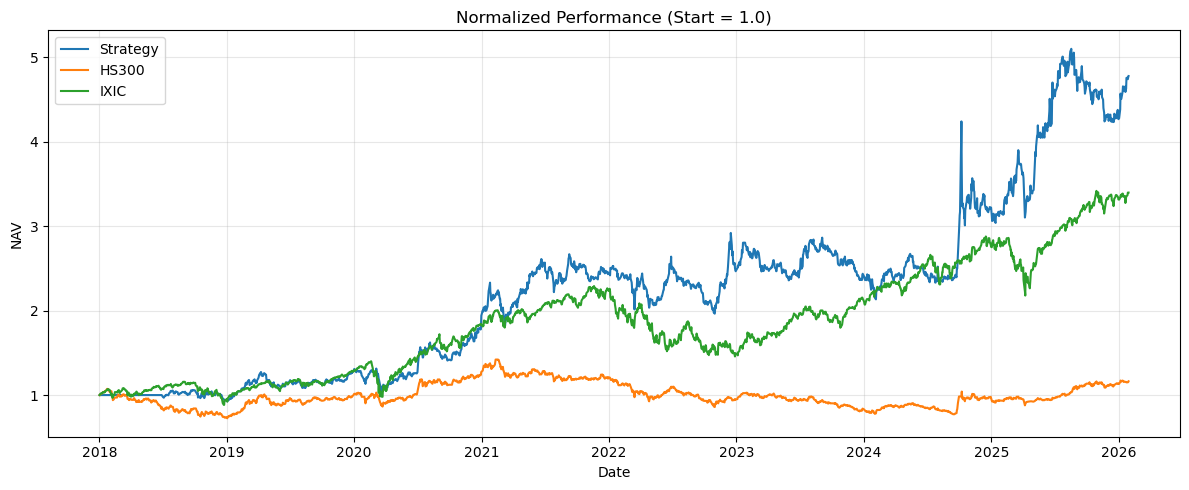

In [7]:
# 曲线对比绘图（若 matplotlib 可用）
if plt is None:
    print('skip plot (matplotlib unavailable)')
else:
    plt.figure(figsize=(12, 5))
    plt.plot(dates, nav, label='Strategy')
    if hs300_nav is not None:
        plt.plot(dates, hs300_nav, label='HS300')
    if ixic_nav is not None:
        plt.plot(dates, ixic_nav, label='IXIC')
    plt.title('Normalized Performance (Start = 1.0)')
    plt.xlabel('Date')
    plt.ylabel('NAV')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [8]:
# 指标计算：Sharpe、月胜率、年胜率（策略 + 基准）

def daily_returns(nav: list[float]) -> list[float]:
    out = []
    for i in range(1, len(nav)):
        if nav[i-1] > 0:
            out.append(nav[i] / nav[i-1] - 1.0)
    return out


def sharpe(nav: list[float], ann_factor: int = 252) -> float:
    r = daily_returns(nav)
    if len(r) < 2:
        return float('nan')
    mu = float(np.mean(r))
    sig = float(np.std(r, ddof=0))
    if sig <= 0:
        return 0.0
    ann_ret = (1 + mu) ** ann_factor - 1
    ann_vol = sig * math.sqrt(ann_factor)
    return float(ann_ret / ann_vol) if ann_vol > 0 else 0.0


def cagr(nav: list[float], ann_factor: int = 252) -> float:
    r = daily_returns(nav)
    if not r:
        return float('nan')
    return float((nav[-1] / nav[0]) ** (ann_factor / len(r)) - 1.0)


def max_drawdown(nav: list[float]) -> float:
    if not nav:
        return float('nan')
    peak = nav[0]
    mdd = 0.0
    for x in nav[1:]:
        if x > peak:
            peak = x
        dd = x / peak - 1.0
        if dd < mdd:
            mdd = dd
    return float(mdd)


def win_rate_daily(nav: list[float]) -> float:
    r = daily_returns(nav)
    if not r:
        return float('nan')
    return float(sum(1 for x in r if x > 0) / len(r))


def period_returns(dates: list[dt.datetime], nav: list[float], key_fn) -> list[float]:
    if len(nav) < 2:
        return []
    groups = {}
    for d, v in zip(dates, nav):
        k = key_fn(d)
        if k not in groups:
            groups[k] = [v, v]
        else:
            groups[k][1] = v
    rets = []
    for first, last in groups.values():
        if first and first > 0 and last is not None:
            rets.append(last / first - 1.0)
    return rets


def period_win_rate(dates: list[dt.datetime], nav: list[float], key_fn) -> float:
    rets = period_returns(dates, nav, key_fn)
    if not rets:
        return float('nan')
    return float(sum(1 for r in rets if r > 0) / len(rets))


def summarize(name: str, dates: list[dt.datetime], nav: list[float]):
    return {
        'Name': name,
        'CAGR': cagr(nav),
        'Sharpe': sharpe(nav),
        'MaxDD': max_drawdown(nav),
        'DailyWin': win_rate_daily(nav),
        'MonthlyWin': period_win_rate(dates, nav, lambda x: (x.year, x.month)),
        'AnnualWin': period_win_rate(dates, nav, lambda x: x.year),
    }

rows = [summarize('Strategy', dates, nav)]
if hs300_nav is not None:
    rows.append(summarize('HS300', dates, hs300_nav))
if ixic_nav is not None:
    rows.append(summarize('IXIC', dates, ixic_nav))

for r in rows:
    print(
        f"{r['Name']:<8} CAGR={r['CAGR']:.2%} Sharpe={r['Sharpe']:.2f} MaxDD={r['MaxDD']:.2%} "
        f"DailyWin={r['DailyWin']:.2%} MonthlyWin={r['MonthlyWin']:.2%} AnnualWin={r['AnnualWin']:.2%}"
    )

Strategy CAGR=21.25% Sharpe=0.94 MaxDD=-29.05% DailyWin=48.78% MonthlyWin=49.48% AnnualWin=77.78%
HS300    CAGR=1.88% Sharpe=0.20 MaxDD=-45.60% DailyWin=48.24% MonthlyWin=43.30% AnnualWin=55.56%
IXIC     CAGR=16.26% Sharpe=0.83 MaxDD=-36.40% DailyWin=53.76% MonthlyWin=60.82% AnnualWin=77.78%


## 凯利公式：整体仓位建议

这里基于策略收益（支持按日/按月）估计凯利比例；本 notebook 默认按月计算，并给出 1/2 Kelly（保守）作为建议的“总仓位占比”。

In [ ]:
# Kelly 计算（支持按日/按月）
KELLY_FREQ = "monthly"  # "daily" | "monthly"

if KELLY_FREQ == "daily":
    rets = daily_returns(nav)
    min_samples = 50
elif KELLY_FREQ == "monthly":
    rets = period_returns(dates, nav, lambda x: (x.year, x.month))
    min_samples = 24
else:
    raise ValueError(f"Unknown KELLY_FREQ: {KELLY_FREQ}")

print('Kelly freq:', KELLY_FREQ, 'n:', len(rets))


def kelly_discrete(rs: list[float]) -> float:
    wins = [x for x in rs if x > 0]
    losses = [x for x in rs if x < 0]
    if len(rs) < min_samples or len(losses) == 0:
        return float('nan')
    p = len(wins) / len(rs)
    avg_win = float(np.mean(wins)) if wins else 0.0
    avg_loss = float(-np.mean(losses)) if losses else 0.0
    if avg_win <= 0 or avg_loss <= 0:
        return float('nan')
    b = avg_win / avg_loss
    q = 1 - p
    return float((b * p - q) / b)


def kelly_mu_sigma(rs: list[float]) -> float:
    if len(rs) < min_samples:
        return float('nan')
    mu = float(np.mean(rs))
    var = float(np.mean([(x - mu) ** 2 for x in rs]))
    if var <= 0:
        return float('nan')
    return float(mu / var)

k_d = kelly_discrete(rets)
k_c = kelly_mu_sigma(rets)

cands = [x for x in [k_d, k_c] if not math.isnan(x) and x > 0]
kelly_raw = min(cands) if cands else float('nan')
kelly_clipped = float(np.clip(kelly_raw, 0.0, 1.0)) if not math.isnan(kelly_raw) else float('nan')
fractional_kelly = (0.5 * kelly_clipped) if not math.isnan(kelly_clipped) else float('nan')

print('Kelly (discrete):', k_d)
print('Kelly (mu/sigma^2):', k_c)
print('Kelly (chosen, clipped):', kelly_clipped)
print('Fractional Kelly (1/2):', fractional_kelly)

## 当前（最新交易日）推荐组合与仓位

- 用最新交易日 `T` 执行
- 用 `T-1` 计算溢价并选股（避免未来函数）
- 输出目标权重（sum=1）与按 1/2 Kelly 缩放后的建议仓位（sum<=Kelly）

In [ ]:
# 生成当前推荐组合
from pprint import pprint

last_trade_date = trade_dates[-1]
prev_trade_date = trade_dates[-2] if len(trade_dates) >= 2 else None
print('latest trade_date:', last_trade_date, 'prev:', prev_trade_date)

if prev_trade_date is None:
    raise RuntimeError('Not enough bars')

premium_recs = strat._load_premium_for_date(prev_trade_date)  # noqa: SLF001 (notebook usage)
if not premium_recs:
    print('No premium records for', prev_trade_date)
else:
    sorted_recs = sorted(premium_recs, key=lambda r: r.premium_pct)
    bottom = sorted_recs[:BOTTOM_K]
    top = sorted_recs[-TOP_K:]

    a_symbols = [r.cn_code for r in bottom]
    h_symbols = [r.hk_code for r in top]

    w_each_a = (1 - CAPITAL_SPLIT) / len(a_symbols) if a_symbols else 0.0
    w_each_h = CAPITAL_SPLIT / len(h_symbols) if h_symbols else 0.0

    rows = []
    for r in bottom:
        rows.append({
            'symbol': r.cn_code,
            'leg': 'A',
            'pair_name': r.name,
            'premium_pct': float(r.premium_pct),
            'target_weight': float(w_each_a),
            'kelly_weight': float(w_each_a * fractional_kelly) if not math.isnan(fractional_kelly) else float('nan'),
        })
    for r in top:
        rows.append({
            'symbol': r.hk_code,
            'leg': 'H',
            'pair_name': r.name,
            'premium_pct': float(r.premium_pct),
            'target_weight': float(w_each_h),
            'kelly_weight': float(w_each_h * fractional_kelly) if not math.isnan(fractional_kelly) else float('nan'),
        })

    print('Signal date (premium):', prev_trade_date, 'Trade date:', last_trade_date)
    rows_sorted = sorted(rows, key=lambda x: (x['leg'], -x['premium_pct']))
    pprint(rows_sorted)

    print('Target weights sum:', round(sum(r['target_weight'] for r in rows_sorted), 6))
    if not math.isnan(fractional_kelly):
        print('Kelly-scaled weights sum:', round(sum(r['kelly_weight'] for r in rows_sorted), 6))